In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
from scipy.special import gammainc

In [4]:
connectivity_min, connectivity_max = 0,20
delay_min, delay_max = 0,5
# random_input_span = (1.2,2.8)
# random_input_span = (9.5,9.5)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 100
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'
version = '_v2.0'
# version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [5]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [6]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [7]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [8]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [9]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    table = table.dropna(axis=1, how='all')
    return table

def nested_dict_to_vectors(given_dict):
    coordinates = []
    for x in given_dict:
        for y in given_dict[x]:
            coordinates.append([x,y,given_dict[x][y]])
    return np.array(coordinates).T

def create_contour_phase_space(given_dict, title, plot_points = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    grid_x, grid_y = np.mgrid[g_arr[0]:g_arr[-1]:500j, delay_arr[0]:delay_arr[-1]:500j]
    
    points = nested_dict_to_vectors(given_dict)[0:2].T
    values = nested_dict_to_vectors(given_dict)[2]
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    extent = [min(g_arr),max(g_arr),min(delay_arr),max(delay_arr)]    
    
    filtered_grid = median_filter(grid_z.T, size = 20)
    
    ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
    C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)
    
    if plot_points == True: ax.plot(points[:,0], points[:,1], 'w.', ms=1)
    
    ax.set_title('{} phase space'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig, ax

In [10]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [11]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
g_arr = np.sort( sigma_table.columns )
delay_arr = np.sort( sigma_table.index )

In [12]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [13]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.1,7.2,7.3,...,8.6,8.7,8.8,8.9,9.0,9.5,10.0,10.5,11.0,11.5
delay,,,,,,,,,,,,,,,,,,,,,
0.01,0.129417,0.132223,0.141768,0.144243,0.161658,0.177506,0.233843,0.250517,0.263289,0.295764,...,0.687240,0.690908,0.693234,0.693859,0.696070,0.694472,0.689033,0.682794,0.678172,0.668553
0.06,0.127274,0.134293,0.136930,0.146159,0.158681,0.184869,0.227931,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.710850,0.711666,0.707439,0.700253,0.691001,0.685185
0.11,0.126101,0.131062,0.137950,0.148018,0.159256,0.183662,0.237423,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714442,0.712187,0.707553,0.701958,0.696950,0.690901
0.16,0.126386,0.134303,0.137485,0.143203,0.164122,0.183448,0.229172,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.711869,0.710055,0.707005,0.704451,0.697431,0.694503
0.21,0.127464,0.130379,0.134937,0.145540,0.158389,0.181929,0.234654,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.708780,0.711725,0.706778,0.704682,0.700508,0.698951
0.26,0.126785,0.129797,0.139106,0.144379,0.155990,0.177875,0.229812,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.703691,0.708080,0.707809,0.701194,0.699545,0.697084
0.31,0.127327,0.131096,0.136666,0.151558,0.158719,0.180393,0.230065,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.697926,0.705451,0.703725,0.705575,0.717660,0.727230
0.36,0.127830,0.130618,0.137351,0.147011,0.157797,0.187371,0.229831,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.555822,0.892771,0.892291,0.896506,0.886080,0.876849
0.41,0.127367,0.134152,0.138995,0.152173,0.160059,0.195090,0.262788,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.870618,0.874743,0.871757,0.859847,0.847468,0.835802


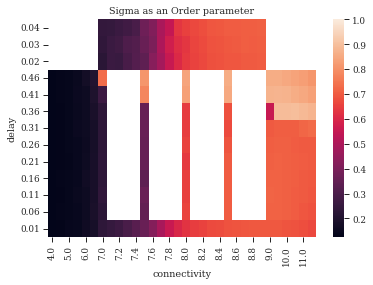

In [14]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

# ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [15]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp\ipykernel_3200\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


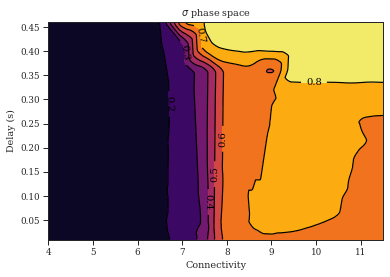

In [16]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp\ipykernel_3200\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


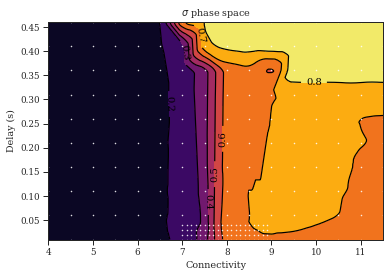

In [17]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_points_plotted_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

## Transition point approx.

In [18]:
def first_trans_point_non_repulsive(alpha, g, d):
    return 2*np.pi/gammainc(2,alpha*d*1)

def second_trans_point_non_repulsive(alpha, g, d):
    D = alpha*d
    return 2*np.pi*gammainc(2,D) / (1 - np.e**(-D)*(D**3 + 3*D**2 + 6*D + 6)/6 )

def first_trans_point_rotational(alpha, g, d, random_input_span):
    D = alpha*d
    a = random_input_span[0]
    num = a + 1
    denom = gammainc(2,D)**2 * (a - 1) - 2 * gammainc(2,D)
    return 2*np.pi*np.sqrt( num / denom )

### First approx of transition point 

C:\Users\mohsen\AppData\Local\Temp\ipykernel_3200\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


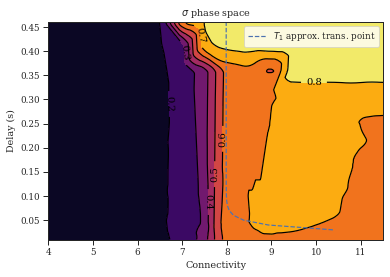

In [28]:

c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = False)

delay_mesh = np.arange(min(delay_arr)+0.02,max(delay_arr),0.01)
g_star_one = np.zeros_like(delay_mesh)
g_star_two = np.zeros_like(delay_mesh)

if neuron_model == current_models[2]:
    for i,d in enumerate(delay_mesh):
        g_star_one[i] = first_trans_point_non_repulsive(alpha, g, d)
        g_star_two[i] = second_trans_point_non_repulsive(alpha, g, d)

    c_ax.plot( g_star_one, delay_mesh, 'b--', label = r'$T_1$ approx. trans. point')
    c_ax.plot( g_star_two, delay_mesh, 'g--', label = r'$T_2$ approx. trans. point')
elif neuron_model == current_models[1]:
    for i,d in enumerate(delay_mesh):
        g_star_one[i] = first_trans_point_rotational(alpha, g, d, random_input_span)
#         g_star_one[i] = first_trans_point_non_repulsive(alpha, g, d)

    c_ax.plot( g_star_one, delay_mesh, 'b--', label = r'$T_1$ approx. trans. point')
    
c_ax.legend(loc='upper right')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_analytical_trans_points_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp\ipykernel_3200\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


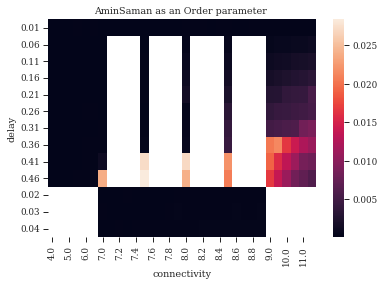

In [20]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    c_fig, c_ax = create_contour_phase_space(amin_saman_param_glossary_dict, 'AminSaman')
    c_fig.savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [21]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.1,7.2,7.3,...,8.6,8.7,8.8,8.9,9.0,9.5,10.0,10.5,11.0,11.5
delay,,,,,,,,,,,,,,,,,,,,,
0.01,0.026171,0.074906,0.080775,0.078989,0.026490,0.026497,0.080322,0.026660,0.079936,0.080257,...,0.082645,0.082919,0.083333,0.083403,0.083752,0.085034,0.086281,0.087566,0.088968,0.090171
0.06,0.178571,0.060976,0.189753,0.059809,0.036010,0.176991,0.025767,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.189036,0.192308,0.195312,0.198413,0.201207,0.204499
0.11,0.286533,0.271003,0.288184,0.261780,0.273973,0.280112,0.021519,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.294118,0.299401,0.304878,0.308642,0.313480,0.318471
0.16,0.396825,0.129702,0.413223,0.389105,0.022346,0.128535,0.025336,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.398406,0.406504,0.413223,0.420168,0.427350,0.434783
0.21,0.704225,0.432900,0.438596,0.467290,0.523560,0.462963,0.028241,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.502513,0.512821,0.523560,0.531915,0.543478,0.555556
0.26,0.729927,0.793651,0.775194,0.027624,0.115875,0.193050,0.052715,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.606061,0.617284,0.632911,0.645161,0.657895,0.671141
0.31,0.800000,0.826446,0.900901,0.862069,0.020627,0.035778,0.226244,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.709220,0.724638,0.740741,0.757576,0.793651,0.819672
0.36,0.900901,1.063830,0.952381,0.952381,0.925926,0.961538,0.961538,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.980392,1.041667,1.052632,1.086957,1.098901,1.111111
0.41,1.041667,1.052632,1.052632,1.000000,1.052632,1.030928,1.030928,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.111111,1.136364,1.149425,1.176471,1.190476,1.204819


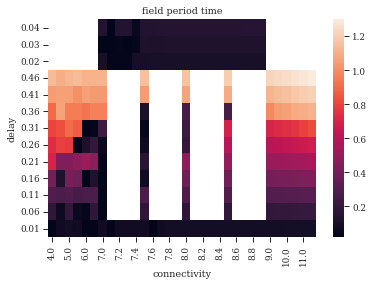

In [22]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('field period time')
ax_field_period.invert_yaxis()

In [23]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp\ipykernel_3200\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


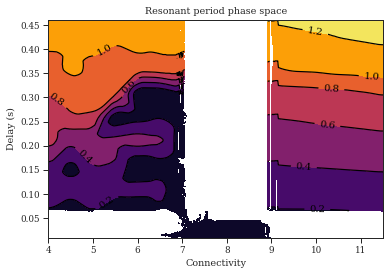

In [24]:
c_fig, c_ax = create_contour_phase_space(field_period_table.abs().to_dict(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [25]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.1,7.2,7.3,...,8.6,8.7,8.8,8.9,9.0,9.5,10.0,10.5,11.0,11.5
delay,,,,,,,,,,,,,,,,,,,,,
0.01,59.183241,62.325160,84.304921,87.042339,113.542824,187.490255,218.793117,307.101899,311.146309,332.754166,...,3463.921919,2671.51543,2562.552916,2816.028323,2890.749133,2127.316988,2598.866321,2666.123434,3106.589833,3266.214087
0.06,65.545058,68.640159,83.912769,101.777378,105.002562,163.742569,222.852795,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3146.920590,4256.532777,4300.085970,3445.993663,4463.922463,3000.697177
0.11,61.868308,71.909427,99.819995,102.818838,133.248612,178.191028,265.163750,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4705.474789,4125.448996,3351.378172,3631.533466,3775.414988,3181.599693
0.16,77.590343,97.695768,93.907784,97.630789,125.299605,142.591199,261.535504,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3905.596093,4342.643273,4633.830701,4627.233634,4396.986096,3884.810793
0.21,83.891910,81.082473,74.832102,109.891111,126.970351,167.145689,277.500421,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4207.691392,3982.231621,4566.698212,3476.241160,4272.122852,3526.068905


C:\Users\mohsen\AppData\Local\Temp\ipykernel_3200\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


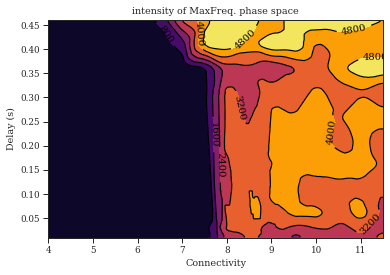

In [26]:
c_fig, c_ax = create_contour_phase_space(field_max_intensity_mod_glossary_dict, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [27]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)